In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import DataLoader

/Users/mungughyeon/miniforge3/envs/Study/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mungughyeon/miniforge3/envs/Study/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/mungughyeon/miniforge3/envs/Study/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/mungughyeon/miniforge3/envs/Study/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mungughyeon/miniforge3/envs/Study/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mungughyeon/miniforge3/envs/Study/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/mungughyeon/miniforge3/envs/Study/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warni

In [2]:
# LeNet-5 Model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)   # (1, 32, 32) -> (6, 28, 28)
        self.pool = nn.AvgPool2d(2, 2)               # (6, 28, 28) -> (6, 14, 14)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5) # (6, 14, 14) -> (16, 10, 10)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16*5*5)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

[Epoch 1/5] Loss: 0.2929
[Epoch 2/5] Loss: 0.0955
[Epoch 3/5] Loss: 0.0632
[Epoch 4/5] Loss: 0.0474
[Epoch 5/5] Loss: 0.0386
Test Accuracy: 98.41%


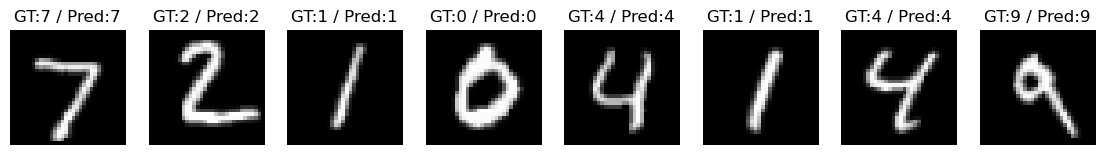

In [ ]:
warnings.filterwarnings('ignore')

def load_data(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()])
    
    trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    return trainloader, testloader

def train_model(model, trainloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

def visualize_predictions(model, testloader, device, num_images=8):
    model.eval()
    images, labels = next(iter(testloader))
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    images = images.cpu()
    
    fig, axes = plt.subplots(1, num_images, figsize=(14, 6))
    for idx in range(num_images):
        img = images[idx].squeeze()
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f"GT:{labels[idx].item()} / Pred:{preds[idx].item()}")
        axes[idx].axis('off')
    plt.show()

def main():
    # 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 64
    num_epochs = 5
    learning_rate = 0.001

    # 데이터 준비
    trainloader, testloader = load_data(batch_size)

    # 모델, 손실함수, 최적화 설정
    model = LeNet5().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_model(model, trainloader, criterion, optimizer, device, num_epochs) # 학습
    evaluate_model(model, testloader, device) # 평가
    visualize_predictions(model, testloader, device) # 예측 결과 시각화

if __name__ == "__main__":
    main()